In [179]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt

In [180]:
# Model / data parameters
n_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)
print("y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)


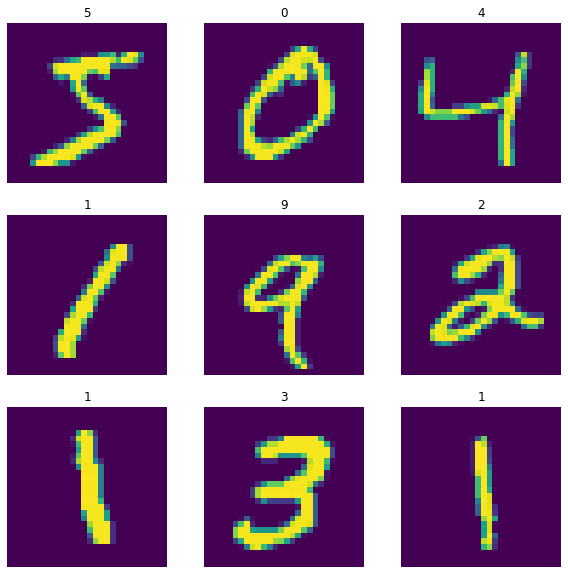

In [181]:
def plot_results(imgs, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.uint8(imgs[i]*255), cmap='gray')
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")

plot_results(x_train[:9], y_train[:9])

In [182]:
def build_model(input_shape, n_classes):
    inp = Input(input_shape)
    x = Flatten()(inp)
    x = Dense(28*28, use_bias=True, activation='relu')(x)
    x = Dense((28*28+10)/2, use_bias=True, activation='relu')(x)
    x = Dense(n_classes, activation="softmax")(x)
    return Model(inp, x)

model = build_model(input_shape, n_classes)
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_22 (Flatten)        (None, 784)               0         
                                                                 
 dense_60 (Dense)            (None, 784)               615440    
                                                                 
 dense_61 (Dense)            (None, 397)               311645    
                                                                 
 dense_62 (Dense)            (None, 10)                3980      
                                                                 
Total params: 931,065
Trainable params: 931,065
Non-trainable params: 0
_________________________________________________________________


In [183]:
def categorical_crossentropy(pred, true):
    #return tf.reduce_mean(tf.keras.metrics.categorical_crossentropy(true, pred, from_logits=False, label_smoothing=0.0, axis=-1))
    loss = -tf.reduce_sum(true * tf.math.log(pred+1e-7))
    #loss = tf.reduce_sum(true * tf.square(true - pred))
    return loss

def accuracy_of_batch(pred, true):
    batch_size = pred.shape[0]
    pred = tf.argmax(pred, axis=1)
    true = tf.argmax(true, axis=1)
    is_equal_elementwise = tf.math.equal(pred, true)
    is_equal_elementwise = tf.cast(is_equal_elementwise, tf.float32)
    accuracy_percentage = tf.reduce_sum(is_equal_elementwise) / batch_size * 100
    return accuracy_percentage

@tf.function
def test_step(img, true, model):
    pred = model(img)
    accuracy = accuracy_of_batch(pred, true)
    return accuracy

@tf.function
def train_step(img, true, model, optimizer):
    with tf.GradientTape() as tape:
        pred = model(img)
        loss = categorical_crossentropy(pred, true)
    gradients = tape.gradient(target=loss, sources=model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return loss

In [184]:
def unison_shuffled_copies(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_tf_dataset(batch_size, x_train, y_train):
    x_train, y_train = unison_shuffled_copies(x_train, y_train)
    x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
    y_train = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size)
    return zip(x_train, y_train)

In [185]:
# Adam-Optimizer
optimizer = Adam(learning_rate=0.001)

batch_size = 128
epochs = 15

mean_epoch_losses = []
mean_epoch_accuracies = []

for epoch in range(epochs):
    train_dataset = get_tf_dataset(batch_size, x_train, y_train)
    test_dataset = get_tf_dataset(batch_size, x_test, y_test)

    # train
    epoch_losses = []
    pb = Progbar(x_train.shape[0], stateful_metrics=['loss'])
    for image, true in train_dataset:
        loss_tensor = train_step(image, true, model, optimizer)
        pb.add(batch_size, values=[('loss', loss_tensor)])
        epoch_losses.append(loss_tensor.numpy())

    mean_epoch_loss = np.mean(epoch_losses)
    mean_epoch_losses.append(mean_epoch_loss)

    # test
    epoch_accuracies = []
    for image, true in test_dataset:
        accuracy_tensor = test_step(image, true, model)
        epoch_accuracies.append(accuracy_tensor.numpy())
    mean_epoch_accuracy = np.mean(epoch_accuracies)
    mean_epoch_accuracies.append(mean_epoch_accuracy)

    print('loss: ' + str(mean_epoch_loss) + ' accuracy: ' + str(mean_epoch_accuracy)+'%')
    

60032/60000 [==============================] - 3s 48us/step - loss: 12.9043
loss: 26.382881 accuracy: 96.58821%
60032/60000 [==============================] - 2s 33us/step - loss: 11.2416
loss: 9.8056135 accuracy: 97.3299%
60032/60000 [==============================] - 2s 34us/step - loss: 9.8061
loss: 6.1314955 accuracy: 97.55736%
60032/60000 [==============================] - 2s 34us/step - loss: 1.2349
loss: 4.254413 accuracy: 97.75514%
60032/60000 [==============================] - 2s 35us/step - loss: 0.7313
loss: 3.382732 accuracy: 97.86392%
60032/60000 [==============================] - 2s 35us/step - loss: 0.6572
loss: 2.9120588 accuracy: 97.77492%
60032/60000 [==============================] - 2s 36us/step - loss: 0.8073
loss: 2.3027706 accuracy: 97.962814%
60032/60000 [==============================] - 2s 38us/step - loss: 1.1860
loss: 1.9276893 accuracy: 98.279274%
60032/60000 [==============================] - 2s 35us/step - loss: 0.7510
loss: 1.4932739 accuracy: 98.0716%
6

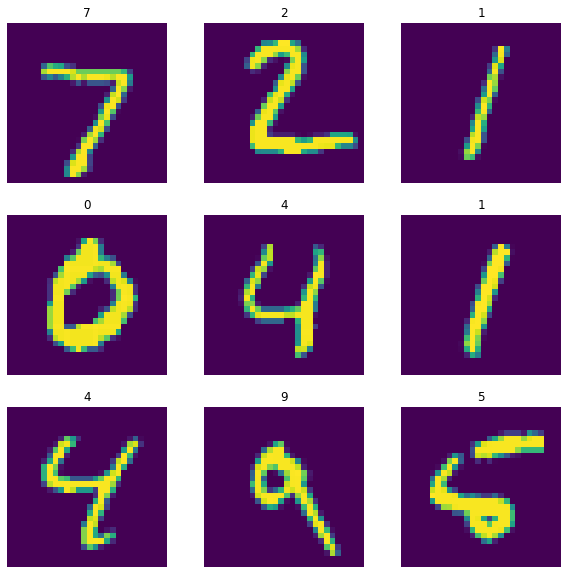

In [186]:
plot_results(x_test[:9], y_test[:9])